**классификатор текстов LSTM**

с сортировкой по длинне строк при формировании батчей

Евгений Борисов <esborisov@sevsu.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

https://rohit-agrawal.medium.com/using-fine-tuned-gensim-word2vec-embeddings-with-torchtext-and-pytorch-17eea2883cd

## Библиотеки

In [1]:
import numpy as np
import numpy.random as rng

import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
# from torchviz import make_dot

In [3]:
tqdm.pandas()

In [4]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [5]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
neg.columns = ff
ppr(neg)

pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
pos.columns = ff
ppr(pos)

data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

data.sample(10)

записей: 111 923
записей: 114 910
записей: 226 833


,id,ttext,ttype
47456,410007779714551808,RT @nadyadorofeeva: Чтоб всем стало теплее ..)))) http://t.co/1AKYGwEUp1,1
43622,414301274415190016,"@bonovoice пробовал, конечно. так как сейчас они отвечают в течение 2 дней, то толку от них никакого нет. придется слать через Priority (",-1
87742,421266293702926338,"если это все продолжится и в этом году, то, простите, с меня хватит :( сохнуть - сохнуть и однажды засохнуть.",-1
95904,411019495000788992,RT @kloninanatali_7: @tochila_danila поправляйтесь)),1
8549,410122041078329344,"Надо заканчивать со скайпом, контактом и бездельем в принципе. :(",-1
40712,409922604817211392,@MarinaTommo_ почему не разрешил? \nПоспи :D Или побей одноклассников,1
75258,410644863550771200,RT @RadioRecord: Новогодняя ёлка :) #radiorecord http://t.co/rdZqNdbjYq,1
27064,409585275544035328,RT @nik_alll: @winteat @ljubovjung @nesezon @poruchik28 @pravodumru @sasa7844 @tat881 @viaxpro @ydubos Доброе утро добрым эмоциям! ),1
22994,409488217885646848,"способ заткнуть рот.Заткни мне рот,а) http://t.co/4eRsfnxA0Y",1
31453,409655764014202880,"еее,калоночки на всю!!!))слушаю свой любимый Rammstein))",1


## очистка данных

In [6]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(' '.join)\
    .str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 96624.80it/s] 


In [7]:
data.sample(3)

,id,ttext,ttype,ttext_clean
57279,416074946675081217,"Я его так люблю, а он своими поступками делает мне больно! Ну почему вот так?(((",-1,"[я, его, так, люблю, а, он, своими, поступками, делает, мне, больно, ну, почему, вот, так, sadsmile]"
48911,410021828762304512,RT @xycohopilox: еще одна флешка на шею %) Теперь у меня с собой будет 3 флешки.,1,"[rt, xycohopilox, еще, одна, флешка, на, шею, теперь, у, меня, с, собой, будет, digit, флешки]"
114869,411368339249041408,RT @SashaDruz: @Dead_Parade ночкиии :з какой фильм?)),1,"[rt, sashadruz, dead, parade, ночкиии, з, какой, фильм, happysmile]"


In [8]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

data['label'] = data['ttype'].apply(lambda y:max(0,y))
data['text'] = data['ttext_clean'].apply(' '.join)

data[['text','label']].sample(3)

записей: 226 833
записей: 226 833


,text,label
185515,даже не осознаю что завтра уже новый год,0
165712,matroskyn ой я не хочу попу такую,0
166129,rt shaxruxmaxmudov malika mileyt я вчера написал что еду домой о конкретно по отдельности никому не сообщил извините дамблдор хотел с,0


In [ ]:
!mkdir -p tmp

In [9]:
data[['text','label']].to_csv('./tmp/data.tsv', index=False, sep='\t')

### кодируем word2vec

In [10]:
# %%time


# https://nlpub.ru/Russian_Distributional_Thesaurus
    
# from gensim.models import KeyedVectors 
# w2v_file = 'tenth.norm-sz500-w7-cb0-it5-min5.w2v'
# w2v = KeyedVectors.load_word2vec_format(w2v_file, binary=True, unicode_errors='ignore')
# w2v.init_sims(replace=True)

In [ ]:
from gensim.models.word2vec import Word2Vec

# WORD2VEC
W2V_SIZE = 128
W2V_WINDOW = 4
W2V_EPOCH = 100
W2V_MIN_COUNT = 2

# Collect corpus for training word embeddings
documents = data['ttext_clean'].values.tolist()

In [ ]:
%%time

# Train Word Embeddings and save
w2v_model = Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT)
w2v_model.build_vocab(documents)

words = list(w2v_model.wv.vocab.keys())
vocab_size = len(words)
print('Vocab size', vocab_size)

In [13]:
%%time

# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save('./tmp/embeddings.txt')

Vocab size 98649


In [14]:
for i in rng.permutation(vocab_size)[:10]:
    w = words[i]
    ww = [ v[0] for v in w2v_model.wv.most_similar(w,topn=5) ]
    print( w,':',ww )

биос : ['повестки', 'полгорода', 'нетбиос', 'браузер', 'аплоадеры']
рабочую : ['новую', 'очередную', 'четвертую', 'актерскую', 'клонированию']
саратове : ['черногорию', 'омске', 'костюме', 'ассортименте', 'гробу']
tatarin : ['bank', 'ynikitenko', 'timurkaaaaaaaaa', 'intellanalytics', 'ir']
нипеля : ['угле', 'зачищать', 'надумали', 'иероглифы', 'трудяга']
папиного : ['отжиманий', 'гостяшек', 'tag', 'плена', 'slavikus']
reuspect : ['rockkimockki', 'lider', 'arbyziik', 'krasovkin', 'valfredarhu']
урфу : ['птвп', 'доберутся', 'дотянули', 'язіке', 'геш']
скриншоты : ['qutecom', 'сукаонатупая', 'неподобающие', 'бездействие', 'викигида']
hamza : ['yazzi', 'ifeelhappylol', 'iamsocasmund', 'красавчиком', 'vitaly']


## строим датасет

In [17]:
# import torch
from torchtext.data import Field
from torchtext.data import TabularDataset

In [18]:
def tokenizer(text): return text.split() 

field_text = Field( sequential=True, use_vocab=True, tokenize=tokenizer, pad_first=True, ) # batch_first=True)
field_label = Field( sequential=False, use_vocab=False, ) # is_target=True, batch_first=True, dtype=torch.long)

/usr/lib/python3.9/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [19]:
field_text.build_vocab( documents, min_freq=W2V_MIN_COUNT)
print (len(field_text.vocab) )

98651


In [20]:
word2vec_vectors = []

for token, idx in tqdm(field_text.vocab.stoi.items()):
    if token in w2v_model.wv.vocab.keys():
        word2vec_vectors.append(torch.FloatTensor(w2v_model.wv[token]))
    else:
        word2vec_vectors.append(torch.zeros(W2V_SIZE))
        
field_text.vocab.set_vectors( field_text.vocab.stoi, word2vec_vectors, W2V_SIZE)

  0%|          | 0/98651 [00:00<?, ?it/s]<ipython-input-20-9c45165e8f08>:5: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:137.)
  word2vec_vectors.append(torch.FloatTensor(w2v_model.wv[token]))
100%|██████████| 98651/98651 [00:00<00:00, 195865.29it/s]


In [21]:
# загружаем датасет в формате Torch
ds = TabularDataset(
            path = './tmp/data.tsv',
            format = 'tsv', #'tsv' for tabs, 'csv' for commas
            fields = [
                ('text',field_text),
                ('label',field_label),
            ],
            skip_header=True,
    )

/usr/lib/python3.9/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/lib/python3.9/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


---

In [22]:
train_ds,test_ds = ds.split(split_ratio=0.7,)

# количество примеров
len(train_ds.examples), len(test_ds.examples)

(158783, 68050)

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [24]:
# раскидываем данные по батчам,
# в один батч будут помещены тексты одинаковой (или близкой) длинны

from torchtext.data import BucketIterator

train_iterator = BucketIterator(
        train_ds, 
        batch_size = 4096, 
        device=device,
        sort=False, 
        shuffle=True,
    )

/usr/lib/python3.9/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [43]:
# for i,batch in enumerate(train_iterator):
#     print( batch.text.shape, batch.label.shape )
#     if i>10: break

## строим модель

In [44]:
# embedding_dim = 128 # размер выхода эмбединга
# embedding_dim = W2V_SIZE
# embedding_input = len(field_text.vocab)

hidden_dim = 64 # размер рекуррентного слоя

# матрица W2V
pre_trained_emb = torch.FloatTensor(field_text.vocab.vectors)

n_classes = 2

In [46]:
pre_trained_emb.shape

torch.Size([98651, 128])

In [27]:
class Model(nn.Module):
    def __init__(self, 
                 #num_embeddings=embedding_input, # размер входа эмбединга (длина OHE)
                 pre_trained_emb = pre_trained_emb,
                 # emb_dim=embedding_dim, # размер выхода эмбединга
                 hid_dim=hidden_dim, # размер рекуррентного слоя
                 output_dim=n_classes # размер выхода
                ):
        super().__init__()
        # self.emb = nn.Embedding(num_embeddings, embedding_dim) 
        self.emb =  nn.Embedding.from_pretrained(pre_trained_emb)
        emb_dim = pre_trained_emb.shape[1]
        self.rnn = nn.LSTM(emb_dim, hid_dim) # рекуррентный слой
        # self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True) # рекуррентный слой
        self.linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой
        self.sftm = nn.Softmax(dim=1)

    def forward(self,x):
        out = self.emb(x)
        _, (hidden, _) = self.rnn(out) # обрабатываем входную последовательность
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self.linear(hidden) # считаем выход сети
        out = self.sftm(out)
        return out 

In [28]:
model = Model()
model

Model(
  (emb): Embedding(98651, 128)
  (rnn): LSTM(128, 64)
  (linear): Linear(in_features=64, out_features=2, bias=True)
  (sftm): Softmax(dim=1)
)

## обучаем модель

In [29]:
model = model.to(device)

In [30]:
loss_function =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [31]:
%%time

epochs = 32
#epochs = 2

hist = []
for i in range(epochs):

    for j,batch in enumerate( train_iterator ):
        xb = batch.text
        yb = batch.label
        
        # print(xb.shape, yb.shape )
        
        optimizer.zero_grad() # обнуляем значения градиента
        out = model(xb) # вычисляем выход, прямой проход
        loss = loss_function(out,yb) # вычисляем значение потери
        loss.backward() # вычисляем значения градиента потери, обратный проход
        
        # clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        
        optimizer.step() # изменяем значения весов модели
        hist.append( loss.item() ) # сохраняем текущее значение потери
        
        # if (j%20)==0: print( f'{j}\t{loss.item()}' )
        
    print(f'{i:3} : {loss.item():.4f}')

  0 : 0.4278
  1 : 0.4219
  2 : 0.4000
  3 : 0.3995
  4 : 0.3897
  5 : 0.3815
  6 : 0.3799
  7 : 0.3776
  8 : 0.3718
  9 : 0.3748
 10 : 0.3684
 11 : 0.3688
 12 : 0.3606
 13 : 0.3560
 14 : 0.3571
 15 : 0.3522
 16 : 0.3562
 17 : 0.3585
 18 : 0.3552
 19 : 0.3477
 20 : 0.3588
 21 : 0.3493
 22 : 0.3487
 23 : 0.3426
 24 : 0.3455
 25 : 0.3450
 26 : 0.3470
 27 : 0.3416
 28 : 0.3460
 29 : 0.3418
 30 : 0.3436
 31 : 0.3420
CPU times: user 1min 25s, sys: 121 ms, total: 1min 25s
Wall time: 1min 25s


In [32]:
# import torch
# torch.nn.utils.clip_grad_norm?

In [33]:
torch.cuda.empty_cache()

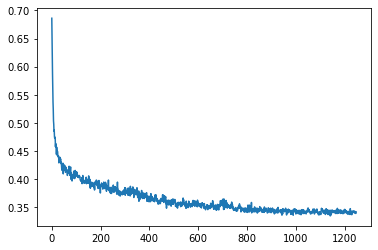

In [34]:
# изменение значения потери в процессе обучения
plt.plot(hist)

In [35]:
# 200 % 100

## тест

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [37]:
from torchtext.data import Iterator

test_iterator = Iterator(
    test_ds, 
    batch_size = 4096, 
    device=device,
    sort=False, 
    shuffle=False,
)

/usr/lib/python3.9/site-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [38]:
label = []
score = []

with torch.no_grad():
    for batch in test_iterator:
        y_pred = model(batch.text) # вычисляем значения регресии
        y = batch.label
        label.append( y.cpu().detach().numpy() )
        score.append( y_pred.cpu().detach().numpy() )

/usr/lib/python3.9/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [39]:
label = np.hstack(label)
score = np.vstack(score)

In [40]:
y_pred = np.argmax( score ,axis=1)

In [41]:
accuracy_score(label, y_pred)

0.9008817046289493

In [42]:
print(classification_report(label, y_pred) )

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     33409
           1       0.90      0.90      0.90     34641

    accuracy                           0.90     68050
   macro avg       0.90      0.90      0.90     68050
weighted avg       0.90      0.90      0.90     68050

